In [1]:
import pathlib
import numpy as np
from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")


2023-11-12 09:13:37,389 [   fytok]     INFO: 
#######################################################################################################################
    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = 0.2.2.dev45+g2d18fac.d20231106 ( extension=0.2.2.dev11+g706f667, imas_version=v3_38_1_dirty ) 

 Run by salmon on Surface at 2023-11-12T09:13:37.389744

#######################################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    time=2.30,
    transport_solver={
        "code": {
            "name": "fytrans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "bvp_rms_mask": [0.96],
                "hyper_diff": 0.0001,
                "max_nodes": 250,
                "equations": {
                    "ion/D/density_thermal": {
                        "profile": 1.5e19,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [2.0e19]},
                        ],
                    },
                    "ion/T/density_thermal": {
                        "profile": 1.5e19,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [2.0e19]},
                        ],
                    },
                    "ion/D/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                    "ion/T/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                
                    "electrons/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                },
            },
        }
    },
)

2023-11-12 09:13:37,513 [   fytok]     INFO: Load module spdm.plugins.data.plugin_xml
2023-11-12 09:13:37,695 [   fytok]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2023-11-12 09:13:37,768 [   fytok]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2023-11-12 09:13:37,797 [   fytok]     INFO: Load module fytok.plugins.transport_solver_numerics.fytrans
2023-11-12 09:13:38,233 [   fytok]     INFO: Load module fytok.plugins.equilibrium.eq_analyze
2023-11-12 09:13:38,237 [   fytok]     INFO: Tokamak simulation : 
-----------------------------------------------------------------------------------------------------------------------
                                                Brief Summary
-----------------------------------------------------------------------------------------------------------------------
Dataset Description:
 
    Device: ITER, Shot: 900003, Run: 0, 
    Run by Salmon on Surface at 2023-11-12T09:13:37.795541, base on ontology "imas/3 modified"

--

In [3]:
tokamak.transport_solver.refresh(
    equilibrium=tokamak.equilibrium,
    core_transport=tokamak.core_transport,
    core_sources=tokamak.core_sources,
)


2023-11-12 09:13:39,928 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fytrans.py:411:_update_coefficient: 0
2023-11-12 09:13:39,931 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fytrans.py:416:_update_coefficient: \left(Function + 0\right)
2023-11-12 09:13:39,938 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fytrans.py:411:_update_coefficient: 0
2023-11-12 09:13:39,943 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fytrans.py:416:_update_coefficient: \left(Function + 0\right)
2023-11-12 09:13:39,952 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fytrans.py:411:_update_coefficient: 0
2023-11-12 09:13:39,954 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fytrans.py:416:_update_coefficient: 

2023-11-12 09:13:45,191 [   fytok]     INFO: Load module spdm.view.view_matplotlib


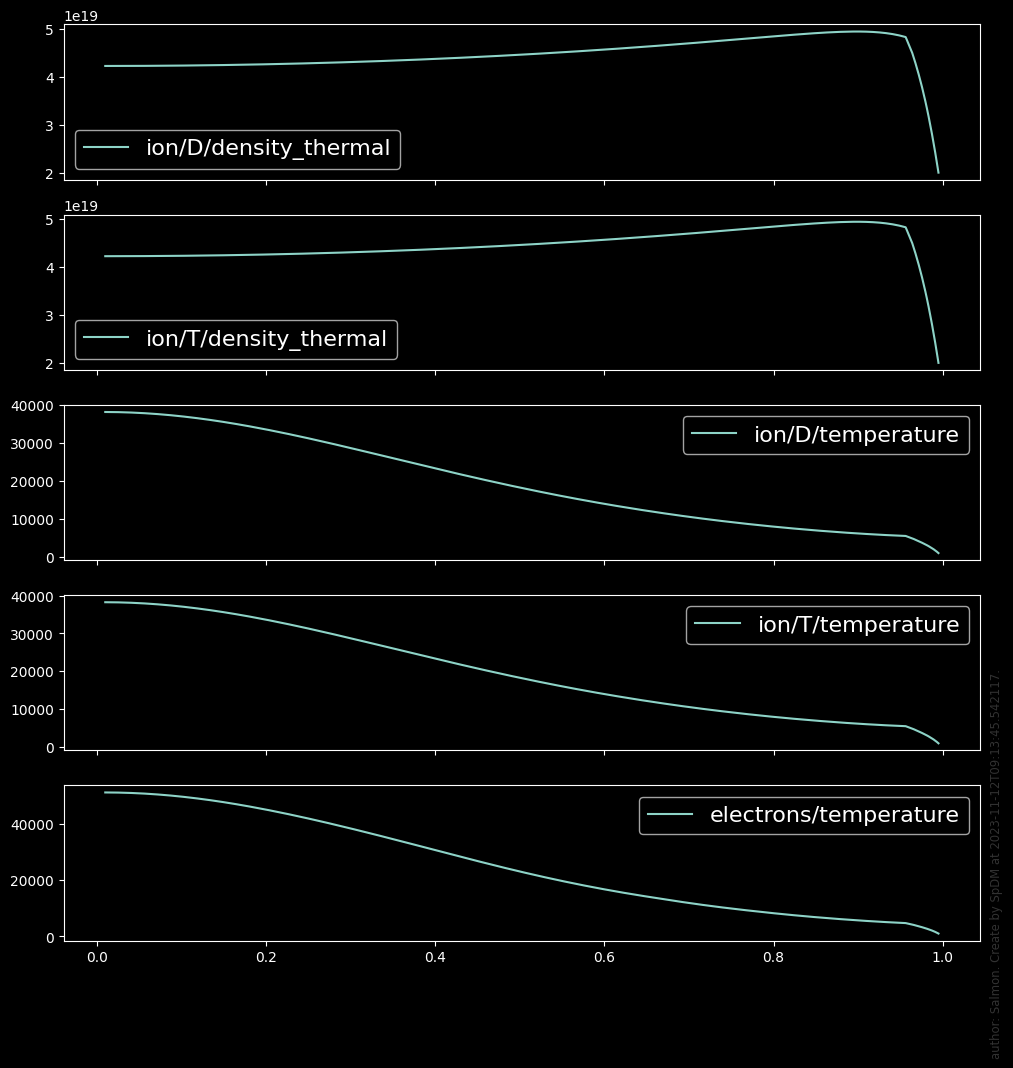

In [4]:
solver_1d = tokamak.transport_solver.time_slice.current.solver_1d
fig = sp_view.plot(
    sum(
        [
            [
                (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                # (equ.primary_quantity.d_dr,f"d({equ.primary_quantity.identifier})/dr"),
                # (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
    x_axis=solver_1d.grid.rho_tor_norm,
)

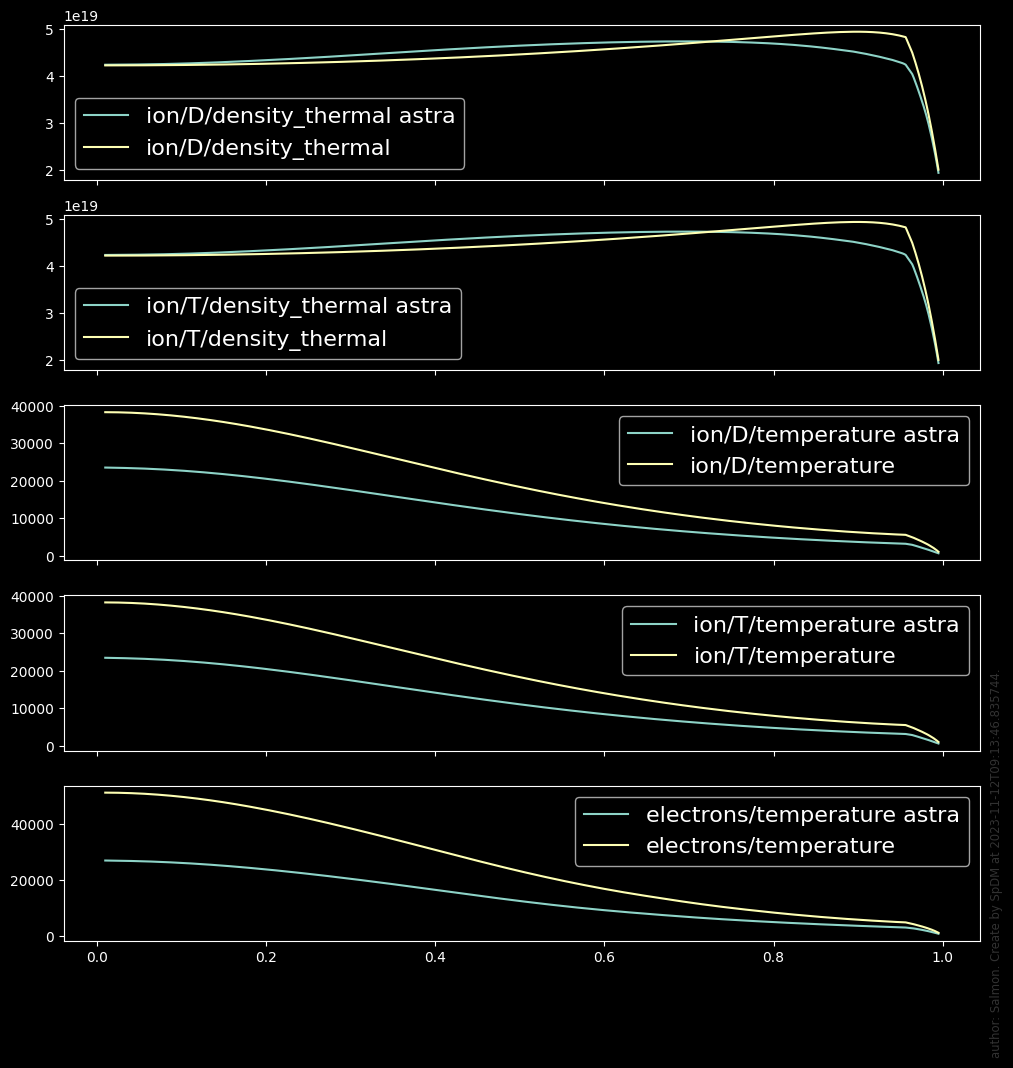

In [5]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot([
    [
        (core_profiles_1d.get(equ.primary_quantity.identifier), rf"{equ.primary_quantity.identifier} astra"),
        (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier}")
    ] for equ in solver_1d.equation
],
    x_axis=solver_1d.grid.rho_tor_norm
)

RuntimeError: Plot [index=0] failed! y_label= "energy"  

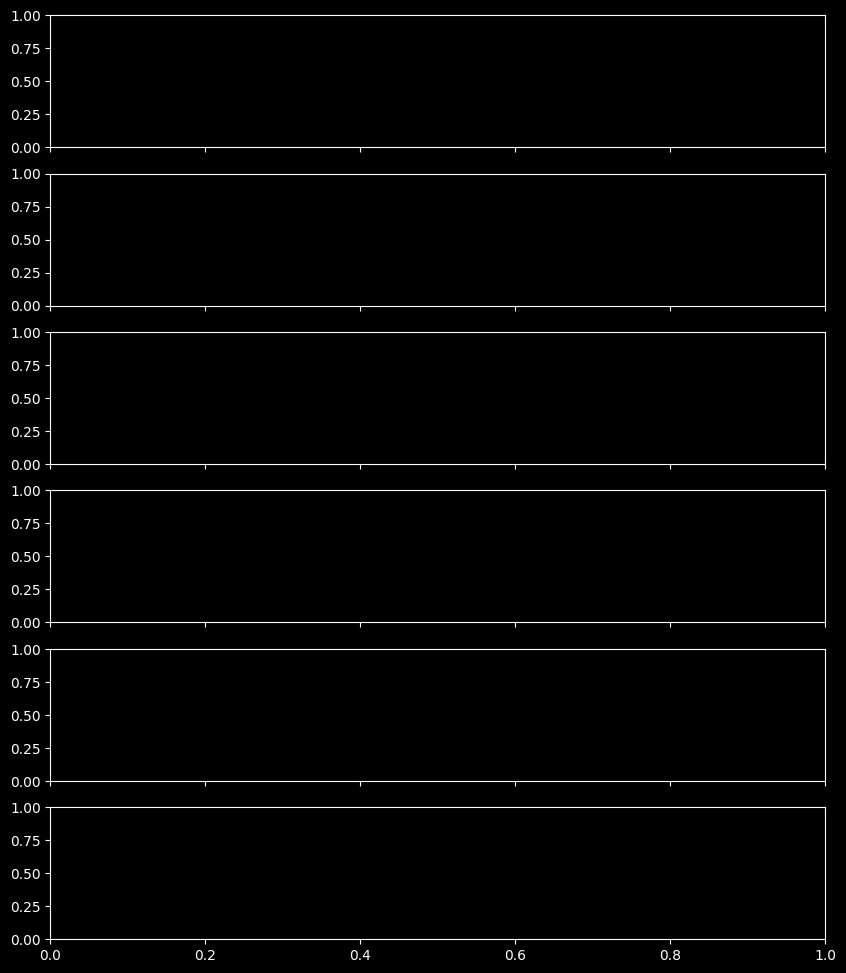

In [7]:
core_sources_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    [
        (core_sources_1d.electrons.energy, r"$Q_e$"),
        (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
        (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
        # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
        # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
        (core_transport_1d.electrons.particles.d, r"$D_e$"),
        (core_sources_1d.ion[0].energy, r"$Q_D$"),
        (core_sources_1d.ion[1].energy, r"$Q_T$"),
    ],
    x_axis=solver_1d.grid.rho_tor_norm,
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


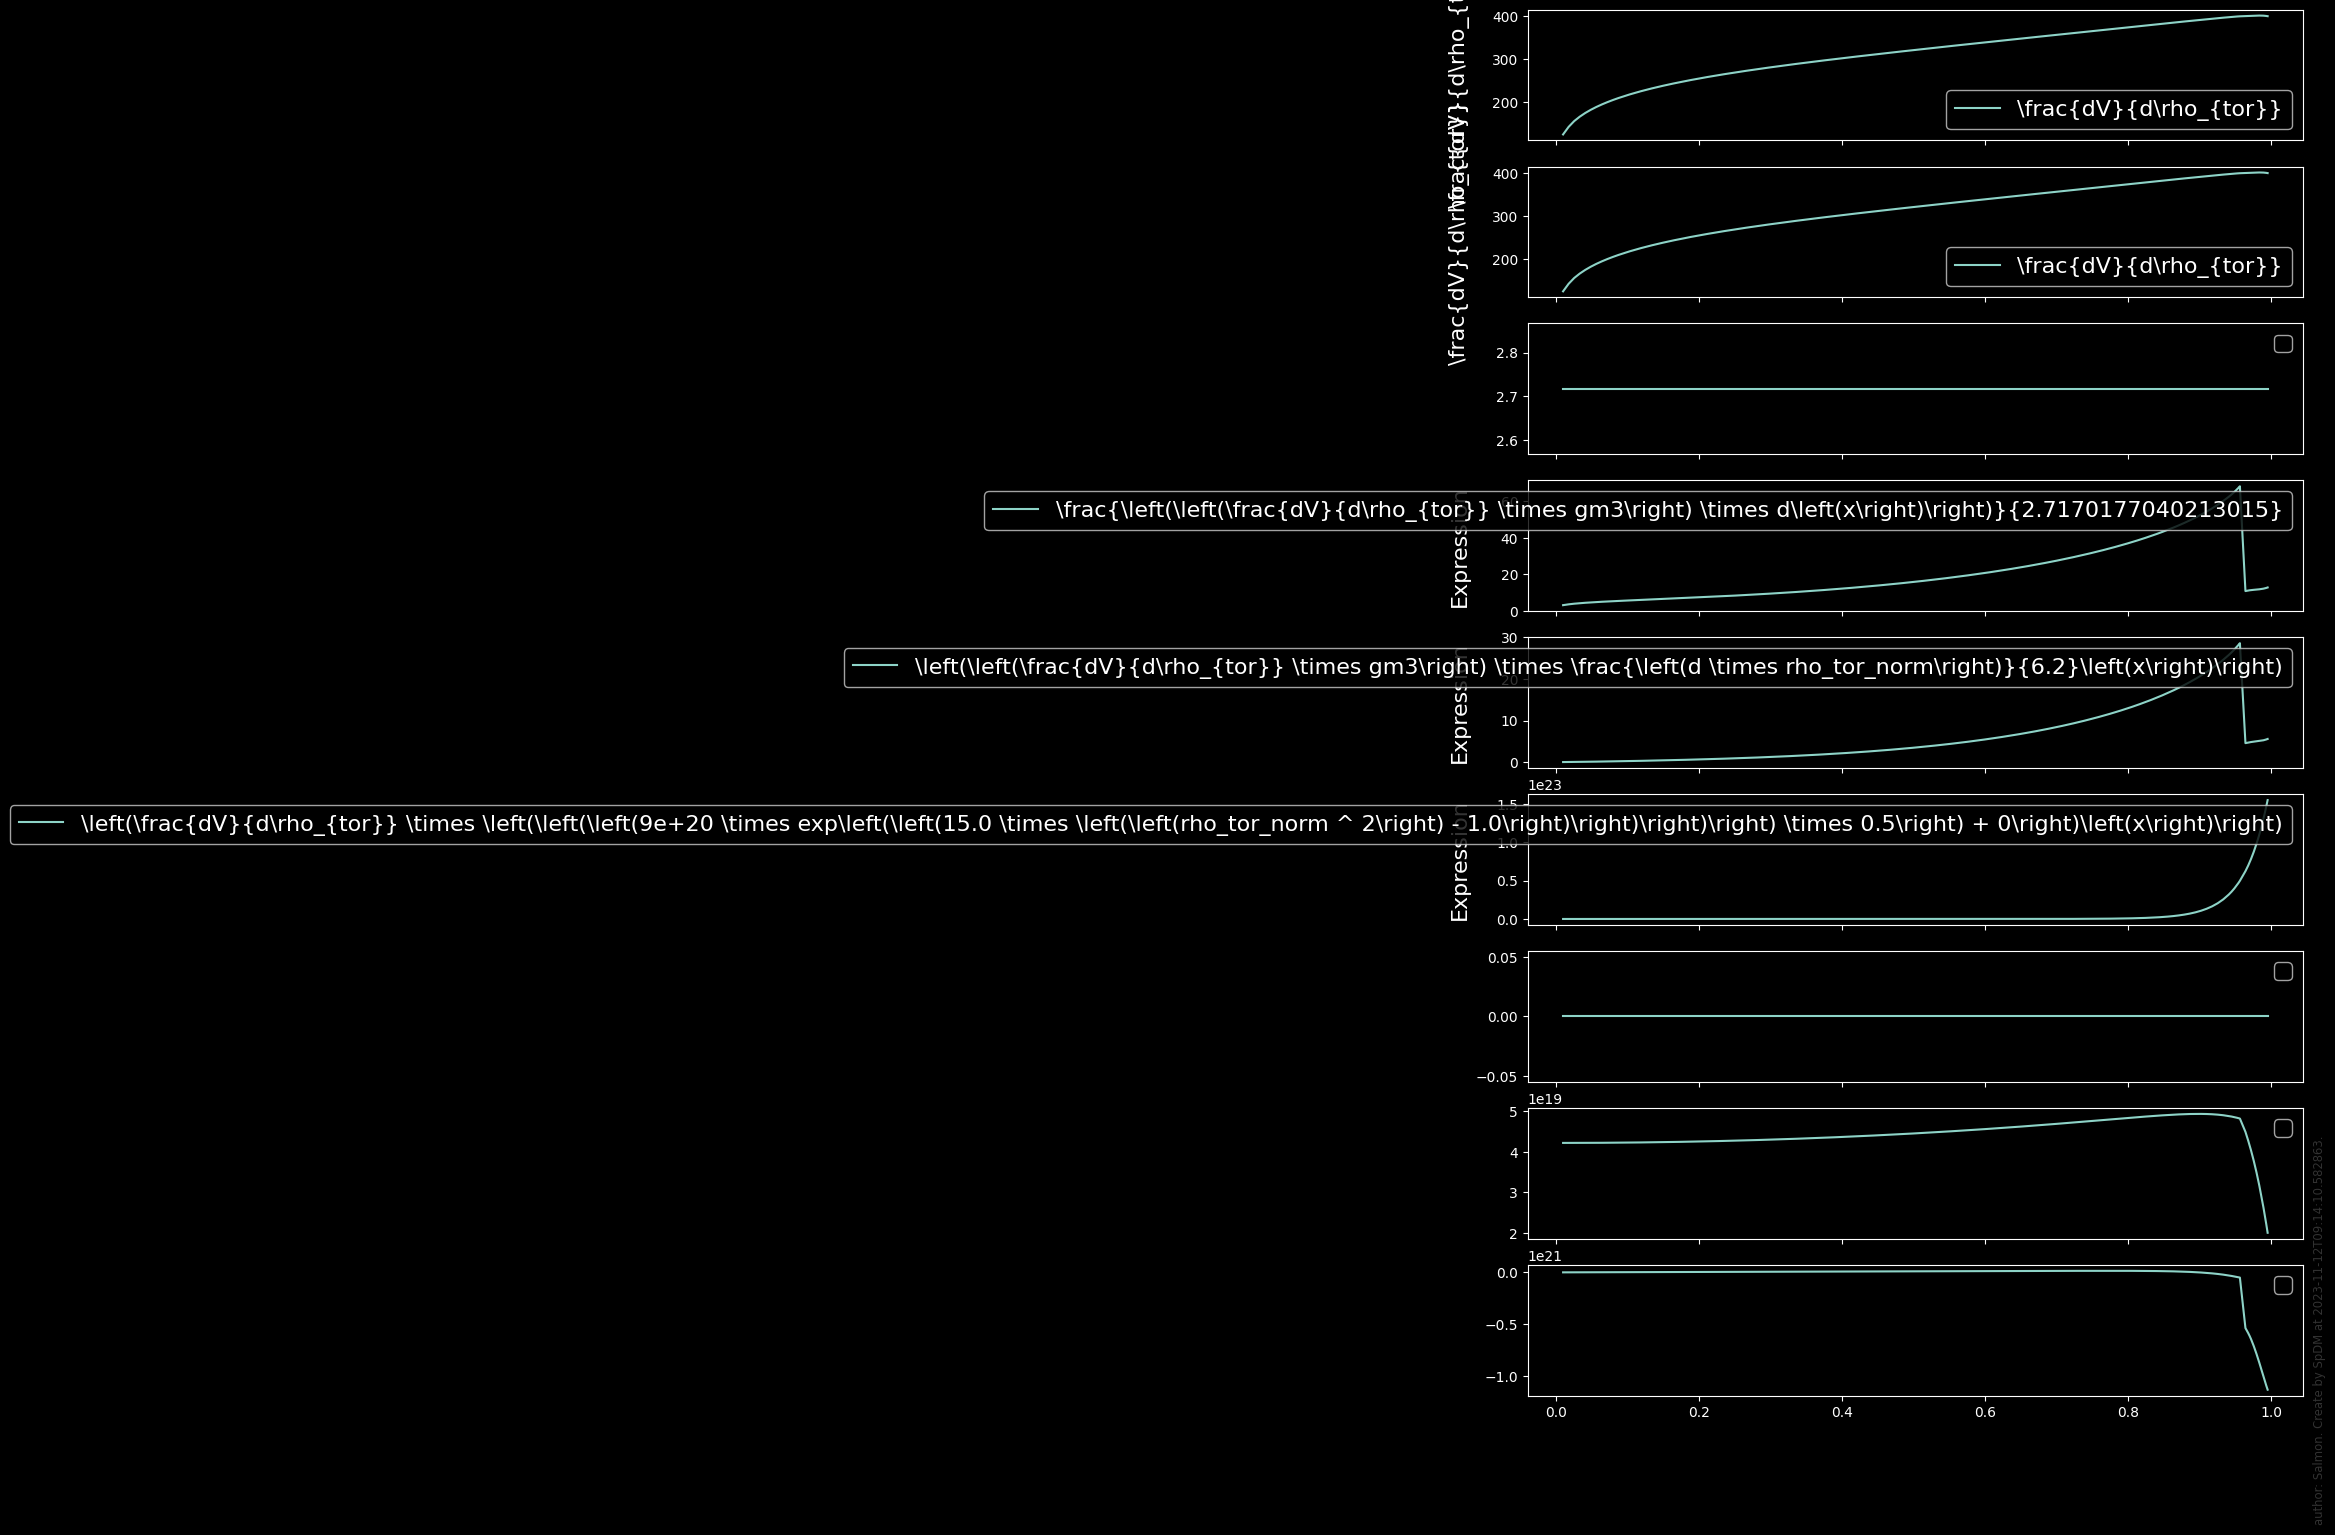

In [8]:
equ = solver_1d.equation[1]
a, b, c, d, e, f, g,*_ = equ.coefficient
x = solver_1d.grid.rho_tor_norm
y       = equ.primary_quantity.profile
yp      = equ.primary_quantity.d_dr
flux    = equ.primary_quantity.flux
dflux   = equ.primary_quantity.dflux_dr
fig = sp_view.plot([
    a, b, c, d, e, f, g,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),

    # ],
    y, yp

    # [

    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
],
    x_axis=x)

In [ ]:
equ.primary_quantity.identifier